In [1]:
%matplotlib inline
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import MaxPooling2D, Conv2D, Input, RepeatVector, Dropout
from keras.layers import Reshape, concatenate, Conv2DTranspose, UpSampling2D, Convolution2D
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from keras import optimizers, callbacks
from scipy import stats
import numpy as np
import keras
import cv2

from common import Metrics

Using TensorFlow backend.


In [2]:
DATA_PATH = 'data/'
X_IMG_PATH = DATA_PATH + 'images/'
Y_IMG_PATH = DATA_PATH + 'labels/'

INPUT_SIZE = (512, 512)

In [3]:
def preprocess_train(filepath):
    img = cv2.imread(filepath)
    img_resized = cv2.resize(img, INPUT_SIZE)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_yuv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YUV)
    
    img_equ = cv2.equalizeHist(img_yuv[:,:,0])
    
    img = np.expand_dims(img_equ, axis=3).astype(np.float32)

    for i in range(len(img.shape)):  # Mean subtraction
        img[i] -= np.mean(img[i])
            
    return img

def preprocess_label(filepath):
    img = cv2.imread(filepath)
    img = cv2.resize(img, INPUT_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(img, 3)
    img = (img / img.max()).astype(np.float32) > .1
    return img

files = os.listdir(X_IMG_PATH)
original = [cv2.imread(X_IMG_PATH + fname) for fname in files]
images_all = np.array([preprocess_train(X_IMG_PATH + fname) for fname in files])
labels_all = np.array([preprocess_label(Y_IMG_PATH + fname) for fname in files])

/home/mateusz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':
/home/mateusz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


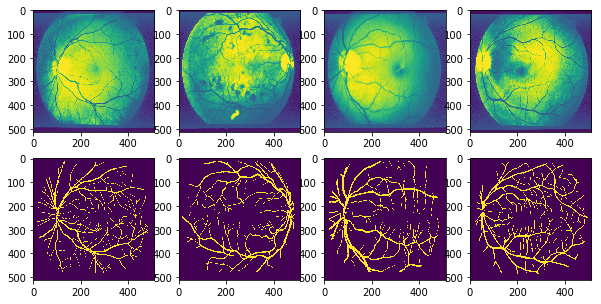

In [4]:
N_SHOW = 4  # How many examples should be shown
f, axarr = plt.subplots(2, N_SHOW, figsize=(10,5))

for i in range(N_SHOW):
    axarr[0, i].imshow(images_all[i,:,:,0])
    axarr[1, i].imshow(labels_all[i,:,:,0])

In [5]:
# Source: https://www.kaggle.com/bguberfain/unet-with-depth
def get_model():
    input_img = Input((*INPUT_SIZE, 1), name='img')

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    optimizer = optimizers.Adam(lr=1e-4)
    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')
    
    return model

In [6]:
get_model().summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  80          img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_2[0][0]                   
_____________________________________

In [7]:
kfold = KFold(n_splits=3)
y_true = [None] * labels_all.shape[0]
y_pred = [None] * labels_all.shape[0]

for train_index, test_index in kfold.split(images_all, labels_all):
    print('Training on new fold')
    X_train_local, X_test_local = images_all[train_index], images_all[test_index]
    y_train_local, y_test_local = labels_all[train_index], labels_all[test_index]
    
    es = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
    model = get_model()
    model.fit(X_train_local, y_train_local,
              batch_size=5, epochs=50,
              validation_data=(X_test_local, y_test_local),
              callbacks=[es], verbose=1)
    
    y_pred_local = model.predict(X_test_local)
    for i, index in enumerate(test_index):
        y_true[index] = labels_all[i]
        y_pred[index] = y_pred_local[i]

Training on new fold
Instructions for updating:
Use tf.cast instead.
Train on 13 samples, validate on 7 samples
Epoch 1/50
13/13 [==============================] - 6s 459ms/step - loss: 0.9693 - acc: 0.9020 - val_loss: 0.7218 - val_acc: 0.7087
Epoch 2/50
13/13 [==============================] - 0s 25ms/step - loss: 0.6352 - acc: 0.7722 - val_loss: 0.5983 - val_acc: 0.8682
Epoch 3/50
13/13 [==============================] - 0s 24ms/step - loss: 0.5564 - acc: 0.8806 - val_loss: 0.6076 - val_acc: 0.8815
Epoch 4/50
13/13 [==============================] - 0s 23ms/step - loss: 0.5319 - acc: 0.8876 - val_loss: 0.5349 - val_acc: 0.8787
Epoch 5/50
13/13 [==============================] - 0s 25ms/step - loss: 0.4789 - acc: 0.8839 - val_loss: 0.4985 - val_acc: 0.8739
Epoch 6/50
13/13 [==============================] - 0s 24ms/step - loss: 0.4573 - acc: 0.8819 - val_loss: 0.4738 - val_acc: 0.8814
Epoch 7/50
13/13 [==============================] - 0s 26ms/step - loss: 0.4318 - acc: 0.8930 - val_l

13/13 [==============================] - 0s 24ms/step - loss: 0.3468 - acc: 0.9070 - val_loss: 0.3551 - val_acc: 0.9013
Epoch 11/50
13/13 [==============================] - 0s 24ms/step - loss: 0.3343 - acc: 0.9077 - val_loss: 0.3097 - val_acc: 0.9038
Epoch 12/50
13/13 [==============================] - 0s 25ms/step - loss: 0.3011 - acc: 0.9095 - val_loss: 0.2914 - val_acc: 0.9043
Epoch 13/50
13/13 [==============================] - 0s 23ms/step - loss: 0.2953 - acc: 0.9087 - val_loss: 0.2884 - val_acc: 0.9052
Epoch 14/50
13/13 [==============================] - 0s 24ms/step - loss: 0.2717 - acc: 0.9109 - val_loss: 0.2842 - val_acc: 0.9100
Epoch 15/50
13/13 [==============================] - 0s 24ms/step - loss: 0.2709 - acc: 0.9129 - val_loss: 0.2800 - val_acc: 0.9067
Epoch 16/50
13/13 [==============================] - 0s 25ms/step - loss: 0.2654 - acc: 0.9127 - val_loss: 0.2571 - val_acc: 0.9132
Epoch 17/50
13/13 [==============================] - 0s 24ms/step - loss: 0.2486 - acc: 

Epoch 22/50
14/14 [==============================] - 0s 22ms/step - loss: 0.2477 - acc: 0.9035 - val_loss: 0.2164 - val_acc: 0.9174
Epoch 23/50
14/14 [==============================] - 0s 22ms/step - loss: 0.2440 - acc: 0.9042 - val_loss: 0.2112 - val_acc: 0.9177
Epoch 24/50
14/14 [==============================] - 0s 23ms/step - loss: 0.2438 - acc: 0.9047 - val_loss: 0.2133 - val_acc: 0.9188
Epoch 25/50
14/14 [==============================] - 0s 23ms/step - loss: 0.2350 - acc: 0.9053 - val_loss: 0.2037 - val_acc: 0.9182
Epoch 26/50
14/14 [==============================] - 0s 22ms/step - loss: 0.2302 - acc: 0.9057 - val_loss: 0.2063 - val_acc: 0.9197
Epoch 27/50
14/14 [==============================] - 0s 22ms/step - loss: 0.2292 - acc: 0.9066 - val_loss: 0.1998 - val_acc: 0.9189
Epoch 28/50
14/14 [==============================] - 0s 23ms/step - loss: 0.2275 - acc: 0.9069 - val_loss: 0.2031 - val_acc: 0.9207
Epoch 29/50
14/14 [==============================] - 0s 24ms/step - loss: 0.

In [25]:
def process_predictions(y_pred):
    new_shape = (y_pred.shape[0], *INPUT_SIZE)
    y_proc = np.reshape(y_pred, new_shape)
    y_proc = y_proc > 0.05
    return y_proc

# Process ground truth samples and predictions
y_true_proc = process_predictions(np.array(y_true))
y_pred_proc = process_predictions(np.array(y_pred))

In [26]:
scores_all = []

for i, (y_true_sample, y_pred_sample) in enumerate(zip(y_true_proc, y_pred_proc)):
    scores = Metrics()
    scores.calculate(y_true_sample.ravel(), y_pred_sample.ravel())
    scores_all.append(scores)
    
    print(i, scores)

0 Acc: 0.93552, sensitivity: 0.64200, specificity: 0.96683, F1-score: 0.65748
1 Acc: 0.85610, sensitivity: 0.86604, specificity: 0.85499, F1-score: 0.54709
2 Acc: 0.92777, sensitivity: 0.81481, specificity: 0.94153, F1-score: 0.71016
3 Acc: 0.92131, sensitivity: 0.64392, specificity: 0.95683, F1-score: 0.65008
4 Acc: 0.91224, sensitivity: 0.65503, specificity: 0.93698, F1-score: 0.56716
5 Acc: 0.90367, sensitivity: 0.83622, specificity: 0.90998, F1-score: 0.59756
6 Acc: 0.90781, sensitivity: 0.77518, specificity: 0.92210, F1-score: 0.62055
7 Acc: 0.61321, sensitivity: 0.48718, specificity: 0.62665, F1-score: 0.19537
8 Acc: 0.64812, sensitivity: 0.49329, specificity: 0.66539, F1-score: 0.21958
9 Acc: 0.66566, sensitivity: 0.54865, specificity: 0.67992, F1-score: 0.26276
10 Acc: 0.60365, sensitivity: 0.55493, specificity: 0.60989, F1-score: 0.24120
11 Acc: 0.65268, sensitivity: 0.51267, specificity: 0.66616, F1-score: 0.20581
12 Acc: 0.61348, sensitivity: 0.53314, specificity: 0.62100, F

In [27]:
metrics_overview = Metrics.mean_metric(scores_all)
print('Mean metrics for {} samples:'.format(len(y_true)))
print(metrics_overview)

Mean metrics for 20 samples:
Acc: 0.66137, sensitivity: 0.67273, specificity: 0.66019, F1-score: 0.35444


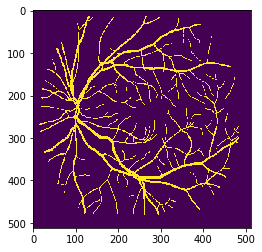

In [28]:
plt.imshow(y_true_proc[0])

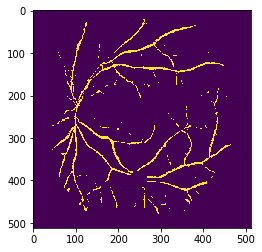

In [17]:
plt.imshow(y_pred_proc[0])